<a href="https://colab.research.google.com/github/Hataeju/Practice/blob/main/part3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. 데이터 준비

### 기본 라이브러리 Import

In [2]:
# 기본라이브러리 import
from google.colab import drive
import os, json, pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 라이브러리 추가 설치 및 Import

In [3]:
!pip install pefile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 2.2 MB/s eta 0:00:00


In [4]:
!pip install yara-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.0 MB/s eta 0:00:00


In [5]:
!pip install cryptography

In [6]:
!pip install asn1crypto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 3.5 MB/s eta 0:00:00


In [7]:
# 추가 라이브러리 import
import pefile
import yara
from cryptography import x509 #코드 사이닝 추출용
from cryptography.hazmat.backends import default_backend
from asn1crypto import cms

### 데이터 로드

In [8]:
# 구글 드라이브 mount
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [9]:
# 데이터 파일 위치
colab_path = "gdrive/My Drive/AI보안교육/part3/"


In [10]:
# 데이터 파일 로드
# 1차시도 전처리까지 마친 데이터에 추가적으로 Feature를 도출한다.
df_train = pd.read_csv(colab_path + "data_with_feature_csv/train_processed1.csv", index_col='hash')
df_train_100 = df_train[:100] # 처음에는 100개정도의 파일로 Feature Engineering이 잘 되는지 검증 후, 주석 처리하여 전체 파일로 확대한다.


In [11]:
df_train

,index_orig,target,is_PE,has_error,size,packer,ifc,section_cnt,ts_entropy,rs_size,yara_https,file_deleted_cnt_many,file_deleted_cnt_unknown,file_deleted_cnt_zero,registry_runkey_modify_false,registry_runkey_modify_true,registry_runkey_modify_unknown
hash,,,,,,,,,,,,,,,,,
ac282b5c526acab44530c0a995d4e23a.vir,6710,1,True,False,-0.370512,Microsoft Visual Basic\n,0x10f,-0.410197,-0.272333,-0.064162,False,False,True,False,False,False,True
7a44a4bf7c9a7f332901e6a792e9c8b5.vir,4725,0,True,False,-0.464084,Microsoft Visual C++\nVisual C++ EXE\n,0x10f,-0.410197,-0.567334,-0.064544,False,False,False,True,True,False,False
1581f524dec2cc3ba8bef37f3ab3d1fd.vir,872,0,True,False,-0.065766,MSLRH\nUPX\nUPX (Delphi) Stub\n,0x818f,-0.410197,1.376177,-0.053071,False,False,False,True,True,False,False
15166c91b32b49734932ccae17426f16.vir,862,1,True,False,0.286939,Petite sign ASL for DLL - *old packer \n,0x10f,-0.410197,1.376177,-0.043716,False,False,False,True,True,False,False
cba8e5374081db7da8d45fa98359d87f.vir,7976,1,True,False,1.792063,PECompact\nPECompact\nPeCompact DLL\nPECompact...,0x10f,-0.588483,1.354430,-0.062461,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ec20114d034e04222f58eb33d5883a8c.vir,9237,1,True,False,-0.459266,unknown,0x103,-0.231911,-0.590486,-0.062524,False,True,False,False,True,False,False
e638f5c2fc248ef94a75bbca6923cb57.vir,9004,0,True,False,0.576398,VMProtect\nASProtect\nASProtect\nASProtect\n,0x103,0.302946,1.376177,1.332020,True,False,False,True,True,False,False
0a9dea1605ae2f00f5e3ab2b41b4548d.vir,419,1,True,False,-0.182131,Petite sign ASL for DLL - *old packer \n,0x10f,-0.410197,1.376177,-0.043716,False,False,False,True,True,False,False


## Feature Engineering


### Image File Characteristics Feature 개선

In [12]:
filename = colab_path + 'data_train/ac282b5c526acab44530c0a995d4e23a.vir'
pe = pefile.PE(filename)
print(hex(pe.FILE_HEADER.Characteristics))

0x10f


In [13]:
print(pe.FILE_HEADER.IMAGE_FILE_RELOCS_STRIPPED, ": 0x0001")
print(pe.FILE_HEADER.IMAGE_FILE_EXECUTABLE_IMAGE, ": 0x0002")
print(pe.FILE_HEADER.IMAGE_FILE_LINE_NUMS_STRIPPED, ": 0x0004")
print(pe.FILE_HEADER.IMAGE_FILE_LOCAL_SYMS_STRIPPED, ": 0x0008")
print(pe.FILE_HEADER.IMAGE_FILE_AGGRESIVE_WS_TRIM, ": 0x0010")
print(pe.FILE_HEADER.IMAGE_FILE_LARGE_ADDRESS_AWARE, ": 0x0020")
print(pe.FILE_HEADER.IMAGE_FILE_16BIT_MACHINE, ": 0x0040")
print(pe.FILE_HEADER.IMAGE_FILE_BYTES_REVERSED_LO, ": 0x0080")
print(pe.FILE_HEADER.IMAGE_FILE_32BIT_MACHINE, ": 0x0100")
print(pe.FILE_HEADER.IMAGE_FILE_DEBUG_STRIPPED, ": 0x0200")
print(pe.FILE_HEADER.IMAGE_FILE_REMOVABLE_RUN_FROM_SWAP, ": 0x0400")
print(pe.FILE_HEADER.IMAGE_FILE_NET_RUN_FROM_SWAP, ": 0x0800")
print(pe.FILE_HEADER.IMAGE_FILE_SYSTEM, ": 0x1000")
print(pe.FILE_HEADER.IMAGE_FILE_DLL, ": 0x2000")
print(pe.FILE_HEADER.IMAGE_FILE_UP_SYSTEM_ONLY, ": 0x4000")
print(pe.FILE_HEADER.IMAGE_FILE_BYTES_REVERSED_HI, ": 0x8000")

True : 0x0001
True : 0x0002
True : 0x0004
True : 0x0008
False : 0x0010
False : 0x0020
False : 0x0040
False : 0x0080
True : 0x0100
False : 0x0200
False : 0x0400
False : 0x0800
False : 0x1000
False : 0x2000
False : 0x4000
False : 0x8000


In [14]:
df_temp = df_train_100.copy()  #1000여개 학습데이터 중 100여개를 통해 빠르게 파악

df_temp['is_RELOCS_STRIPPED'] = None
df_temp['is_LINE_NUMS_STRIPPED'] = None
df_temp['is_LOCAL_SYMS_STRIPPED'] = None
df_temp['is_DEBUG_STRIPPED'] = None
df_temp['is_SYSTEM'] = None
df_temp['is_DLL'] = None

for idx, hash in enumerate(df_temp.index.values):
    filename = colab_path + 'data_train/' + hash
    pe = pefile.PE(filename)
    df_temp.loc[hash, 'is_RELOCS_STRIPPED'] = pe.FILE_HEADER.IMAGE_FILE_RELOCS_STRIPPED
    df_temp.loc[hash, 'is_LINE_NUMS_STRIPPED'] = pe.FILE_HEADER.IMAGE_FILE_LINE_NUMS_STRIPPED
    df_temp.loc[hash, 'is_LOCAL_SYMS_STRIPPED'] = pe.FILE_HEADER.IMAGE_FILE_LOCAL_SYMS_STRIPPED
    df_temp.loc[hash, 'is_DEBUG_STRIPPED'] = pe.FILE_HEADER.IMAGE_FILE_DEBUG_STRIPPED
    df_temp.loc[hash, 'is_SYSTEM'] = pe.FILE_HEADER.IMAGE_FILE_SYSTEM
    df_temp.loc[hash, 'is_DLL'] = pe.FILE_HEADER.IMAGE_FILE_DLL


In [15]:
# 실행파일 악성여부로 피봇테이블 생성하여 확인 : is_RELOCS_STRIPPED
df_temp.groupby(['target', 'is_RELOCS_STRIPPED']).count()

index_orig  is_PE  has_error  size  packer  ifc  \
target is_RELOCS_STRIPPED                                                    
0      False                       36     36         36    36      36   36   
       True                         7      7          7     7       7    7   
1      False                       25     25         25    25      25   25   
       True                        32     32         32    32      32   32   

                           section_cnt  ts_entropy  rs_size  yara_https  ...  \
target is_RELOCS_STRIPPED                                                ...   
0      False                        36          36       36          36  ...   
       True                          7           7        7           7  ...   
1      False                        25          25       25          25  ...   
       True                         32          32       32          32  ...   

                           file_deleted_cnt_unknown  file_deleted_cnt_zero  \
target is_RELOCS_STRIPPED                                                    
0      False                                     36                     36   
       True                                       7                      7   
1      False                                     25                     25   
       True                                      32                     32   

                           registry_runkey_modify_false  \
target is_RELOCS_STRIPPED                                 
0      False                                         36   
       True                                           7   
1      False                                         25   
       True                                          32   

                           registry_runkey_modify_true  \
target is_RELOCS_STRIPPED                                
0      False                                        36   
       True                                          7   
1      False                                        25   
       True                                         32   

                           registry_runkey_modify_unknown  \
target is_RELOCS_STRIPPED                                   
0      False                                           36   
       True                                             7   
1      False                                           25   
       True                                            32   

                           is_LINE_NUMS_STRIPPED  is_LOCAL_SYMS_STRIPPED  \
target is_RELOCS_STRIPPED                                                  
0      False                                  36                      36   
       True                                    7                       7   
1      False                                  25                      25   
       True                                   32                      32   

                           is_DEBUG_STRIPPED  is_SYSTEM  is_DLL  
target is_RELOCS_STRIPPED                                        
0      False                              36         36      36  
       True                                7          7       7  
1      False                              25         25      25  
       True                               32         32      32  

[4 rows x 21 columns]

In [16]:
# 실행파일 악성여부로 피봇테이블 생성하여 확인 : is_DLL
df_temp.groupby(['target', 'is_DLL']).count()

index_orig  is_PE  has_error  size  packer  ifc  section_cnt  \
target is_DLL                                                                 
0      False           22     22         22    22      22   22           22   
       True            21     21         21    21      21   21           21   
1      False           49     49         49    49      49   49           49   
       True             8      8          8     8       8    8            8   

               ts_entropy  rs_size  yara_https  ...  file_deleted_cnt_unknown  \
target is_DLL                                   ...                             
0      False           22       22          22  ...                        22   
       True            21       21          21  ...                        21   
1      False           49       49          49  ...                        49   
       True             8        8           8  ...                         8   

               file_deleted_cnt_zero  registry_runkey_modify_false  \
target is_DLL                                                        
0      False                      22                            22   
       True                       21                            21   
1      False                      49                            49   
       True                        8                             8   

               registry_runkey_modify_true  registry_runkey_modify_unknown  \
target is_DLL                                                                
0      False                            22                              22   
       True                             21                              21   
1      False                            49                              49   
       True                              8                               8   

               is_RELOCS_STRIPPED  is_LINE_NUMS_STRIPPED  \
target is_DLL                                              
0      False                   22                     22   
       True                    21                     21   
1      False                   49                     49   
       True                     8                      8   

               is_LOCAL_SYMS_STRIPPED  is_DEBUG_STRIPPED  is_SYSTEM  
target is_DLL                                                        
0      False                       22                 22         22  
       True                        21                 21         21  
1      False                       49                 49         49  
       True                         8                  8          8  

[4 rows x 21 columns]

### 코드 사이닝 여부

In [17]:
df_temp = df_train_100.copy()

# 디지털 인증서 정보 추출
from cryptography import x509
from cryptography.hazmat.backends import default_backend
from asn1crypto import cms

df_temp['has_cert'] = False

for idx, hash in enumerate(df_temp.index.values):
    try:
        filename = colab_path + 'data_train/' + hash
        pe = pefile.PE(filename)

        sig_offset = pe.OPTIONAL_HEADER.DATA_DIRECTORY[pefile.DIRECTORY_ENTRY["IMAGE_DIRECTORY_ENTRY_SECURITY"]].VirtualAddress
        sig_len = pe.OPTIONAL_HEADER.DATA_DIRECTORY[pefile.DIRECTORY_ENTRY["IMAGE_DIRECTORY_ENTRY_SECURITY"]].Size
        with open(filename, 'rb') as fh:
            fh.seek(sig_offset)
            sig = fh.read(sig_len)
            if len(sig) > 0:
                print("======")
                print(hash)
                df_temp.loc[hash, 'has_cert'] = True
                signature = cms.ContentInfo.load(sig[8:])
                for cert in signature["content"]["certificates"]:
                    parsed_cert = x509.load_der_x509_certificate(cert.dump(), default_backend())
                    print(parsed_cert)
    except Exception as e:
        print(e)

782d61d2f80c2db6258304c4f6be91ce.vir
<Certificate(subject=<Name(C=US,O=Symantec Corporation,CN=Symantec Time Stamping Services CA - G2)>, ...)>
<Certificate(subject=<Name(C=US,O=Symantec Corporation,CN=Symantec Time Stamping Services Signer - G4)>, ...)>
<Certificate(subject=<Name(C=GB,ST=Greater Manchester,L=Salford,O=COMODO CA Limited,CN=COMODO Code Signing CA 2)>, ...)>
<Certificate(subject=<Name(C=US,2.5.4.17=94105,ST=CA,L=San Francisco,STREET=199 Fremont,O=Wireshark Foundation,CN=Wireshark Foundation)>, ...)>
4004c9f7bcfeae7dcd0ab122ca0ee814.vir
<Certificate(subject=<Name(C=US,ST=Washington,L=Redmond,O=Microsoft Corporation,CN=Microsoft Corporation)>, ...)>
<Certificate(subject=<Name(C=US,ST=Washington,L=Redmond,O=Microsoft Corporation,OU=Microsoft Operations Puerto Rico,OU=Thales TSS ESN:B1B7-F67F-FEC2,CN=Microsoft Time-Stamp Service)>, ...)>
<Certificate(subject=<Name(C=US,ST=Washington,L=Redmond,O=Microsoft Corporation,CN=Microsoft Code Signing PCA)>, ...)>
<Certificate(subject

In [18]:
# 실행파일 악성여부로 피봇테이블 생성하여 확인
df_temp.groupby(['target', 'has_cert']).count()

index_orig  is_PE  has_error  size  packer  ifc  section_cnt  \
target has_cert                                                                 
0      False             28     28         28    28      28   28           28   
       True              15     15         15    15      15   15           15   
1      False             57     57         57    57      57   57           57   

                 ts_entropy  rs_size  yara_https  file_deleted_cnt_many  \
target has_cert                                                           
0      False             28       28          28                     28   
       True              15       15          15                     15   
1      False             57       57          57                     57   

                 file_deleted_cnt_unknown  file_deleted_cnt_zero  \
target has_cert                                                    
0      False                           28                     28   
       True                            15                     15   
1      False                           57                     57   

                 registry_runkey_modify_false  registry_runkey_modify_true  \
target has_cert                                                              
0      False                               28                           28   
       True                                15                           15   
1      False                               57                           57   

                 registry_runkey_modify_unknown  
target has_cert                                  
0      False                                 28  
       True                                  15  
1      False                                 57

### Import Address Table

In [19]:
# import DLL & API 추출 가능여부 확인
filename = colab_path + 'data_train/1581f524dec2cc3ba8bef37f3ab3d1fd.vir'
pe = pefile.PE(filename)
try:
    pe.parse_data_directories()
    try:
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            print('==' + entry.dll.decode("utf8") + '==')
            for imp in entry.imports:
                try:
                    api_name = imp.name.decode("utf8")
                    print(api_name)
                except:
                    pass
    except:
        pass
except:
    pass

==KERNEL32.DLL==
LoadLibraryA
GetProcAddress
ExitProcess
==advapi32.dll==
RegCloseKey
==comctl32.dll==
ImageList_Add
==comdlg32.dll==
PrintDlgA
==gdi32.dll==
SaveDC
==ole32.dll==
CoInitialize
==oleaut32.dll==
VarNot
==shell32.dll==
ShellExecuteA
==user32.dll==
GetDC
==winmm.dll==
timeGetTime
==winspool.drv==
OpenPrinterA


In [38]:
df_temp = df_train_100.copy()

api_dict = {
    'api_dll_inj': ['openprocess','virtualallocex','writeprocessmemory','loadlibrarya','getprocaddress','createremotethread'],
    'api_file': ['writefile','lstrcmpia','readfile','deletefilea','createfilea','copyfilea','movefile','createprocessa','findfirstfilea'],
    'api_reg': ['regsetvalueexa','regenumvaluea','regdeletekeya','regcreatekeyexa','openprocesstoken','regopenkeyexa'],
    'api_crypto': ['cryptencrypt','cryptgenkey','cryptexportkey','cryptcreatehash','crypthashdata','cryptderivekey','cryptencrypt','cryptgethashparam','cryptacquirecontexta'],
    'api_network': ['wsastartup','gethostbyname','gethostbyaddr','socket','send', 'recv']
}

# Convert API names in api_dict to lowercase for case-insensitive matching
api_dict_lower = {key: [api.lower() for api in val] for key, val in api_dict.items()}


df_temp['api_dll_inj']=0
df_temp['api_file']=0
df_temp['api_reg']=0
df_temp['api_crypto']=0
df_temp['api_network']=0

for idx, hash in enumerate(df_temp.index.values):
    try:
        filename = colab_path + 'data_train/' + hash
        pe = pefile.PE(filename)

        try:
            pe.parse_data_directories()
            try:
                for entry in pe.DIRECTORY_ENTRY_IMPORT:
                    for imp in entry.imports:
                        try:
                            api_name = imp.name.decode("utf8").lower() # Convert extracted API name to lowercase
                            for (key, val) in api_dict_lower.items():
                                if api_name in val:
                                    df_temp.loc[hash, key] += 1  #대상 PE파일이 이용하려고 하는 API함수가 watch list의 함수명과 일치하는 경우 해당 카테고리의 count 1 증가
                        except:
                            pass
            except:
                pass
        except:
            pass
    except Exception as e:
        print(e)

In [39]:
df_temp

,index_orig,target,is_PE,has_error,size,packer,ifc,section_cnt,ts_entropy,rs_size,...,file_deleted_cnt_unknown,file_deleted_cnt_zero,registry_runkey_modify_false,registry_runkey_modify_true,registry_runkey_modify_unknown,api_dll_inj,api_file,api_reg,api_crypto,api_network
hash,,,,,,,,,,,,,,,,,,,,,
ac282b5c526acab44530c0a995d4e23a.vir,6710,1,True,False,-0.370512,Microsoft Visual Basic\n,0x10f,-0.410197,-0.272333,-0.064162,...,True,False,False,False,True,0,0,0,0,0
7a44a4bf7c9a7f332901e6a792e9c8b5.vir,4725,0,True,False,-0.464084,Microsoft Visual C++\nVisual C++ EXE\n,0x10f,-0.410197,-0.567334,-0.064544,...,False,True,True,False,False,0,0,0,0,0
1581f524dec2cc3ba8bef37f3ab3d1fd.vir,872,0,True,False,-0.065766,MSLRH\nUPX\nUPX (Delphi) Stub\n,0x818f,-0.410197,1.376177,-0.053071,...,False,True,True,False,False,2,0,0,0,0
15166c91b32b49734932ccae17426f16.vir,862,1,True,False,0.286939,Petite sign ASL for DLL - *old packer \n,0x10f,-0.410197,1.376177,-0.043716,...,False,True,True,False,False,2,0,0,0,0
cba8e5374081db7da8d45fa98359d87f.vir,7976,1,True,False,1.792063,PECompact\nPECompact\nPeCompact DLL\nPECompact...,0x10f,-0.588483,1.354430,-0.062461,...,False,True,True,False,False,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0983b1139172eee5789f4b387d091dd5.vir,384,1,True,False,1.046534,Microsoft Visual C++ (DLL)\n,0x23,0.302946,0.151943,-0.064241,...,False,True,True,False,False,5,2,1,0,5
f7863b5c8eb86659d16618470b378900.vir,9665,1,True,False,-0.364791,Microsoft Visual C++\nVC8\nMicrosoft Visual C++\n,0x103,-0.231911,0.274136,-0.064544,...,False,False,True,False,False,6,1,1,0,0
d68e93e467c6761dcb1cd6061b969323.vir,8401,1,True,False,-0.368518,Microsoft Visual C++\nVC8\nMicrosoft Visual C++\n,0x102,-0.053626,0.137605,-0.051165,...,False,False,True,False,False,1,2,0,0,0


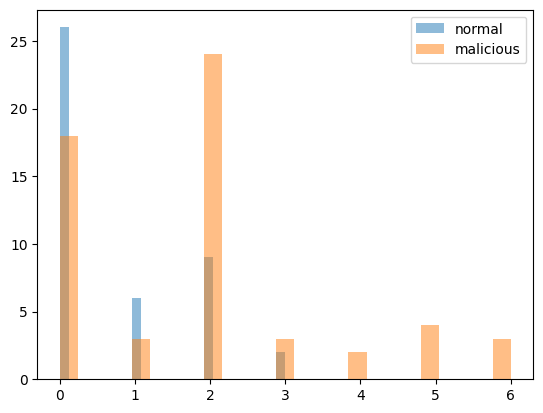

In [29]:
# 실행파일 악성여부로 구분하여 확인 - api_crypto
hist1 = df_temp[df_temp['target']==0]['api_dll_inj']
hist2 = df_temp[df_temp['target']==1]['api_dll_inj']
plt.hist(hist1,label='normal', alpha=0.5, bins=25)
plt.hist(hist2,label='malicious', alpha=0.5, bins=25)
plt.legend(loc=0)

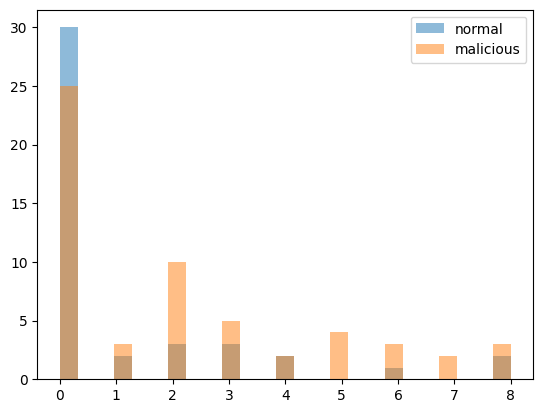

In [30]:
# 실행파일 악성여부로 구분하여 확인 - api_file
hist1 = df_temp[df_temp['target']==0]['api_file']
hist2 = df_temp[df_temp['target']==1]['api_file']
plt.hist(hist1,label='normal', alpha=0.5, bins=25)
plt.hist(hist2,label='malicious', alpha=0.5, bins=25)
plt.legend(loc=0)

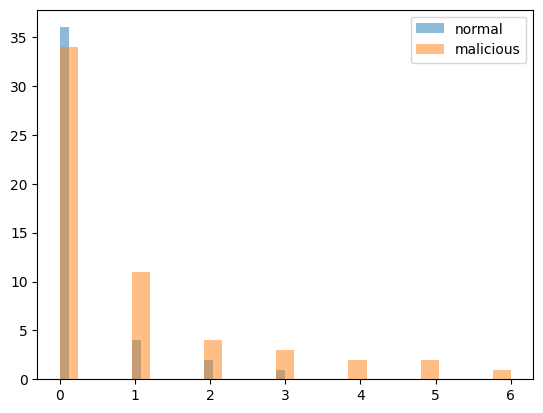

In [31]:
# 실행파일 악성여부로 구분하여 확인 - api_reg
hist1 = df_temp[df_temp['target']==0]['api_reg']
hist2 = df_temp[df_temp['target']==1]['api_reg']
plt.hist(hist1,label='normal', alpha=0.5, bins=25)
plt.hist(hist2,label='malicious', alpha=0.5, bins=25)
plt.legend(loc=0)

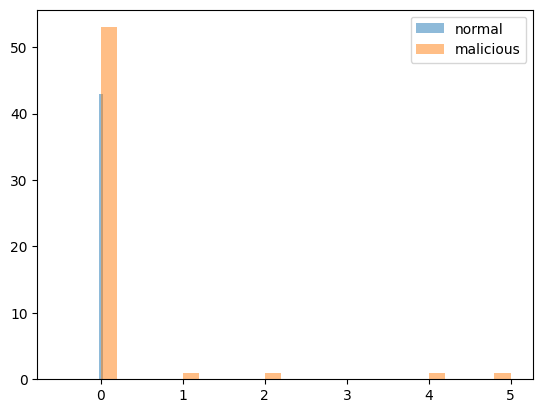

In [32]:
# 실행파일 악성여부로 구분하여 확인 - api_crypto
hist1 = df_temp[df_temp['target']==0]['api_crypto']
hist2 = df_temp[df_temp['target']==1]['api_crypto']
plt.hist(hist1,label='normal', alpha=0.5, bins=25)
plt.hist(hist2,label='malicious', alpha=0.5, bins=25)
plt.legend(loc=0)

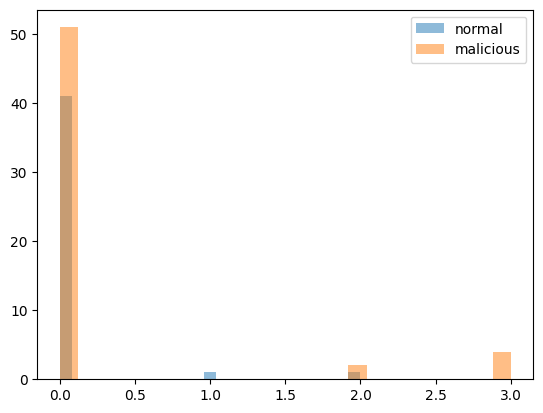

In [33]:
# 실행파일 악성여부로 구분하여 확인 - api_network
hist1 = df_temp[df_temp['target']==0]['api_network']
hist2 = df_temp[df_temp['target']==1]['api_network']
plt.hist(hist1,label='normal', alpha=0.5, bins=25)
plt.hist(hist2,label='malicious', alpha=0.5, bins=25)
plt.legend(loc=0)

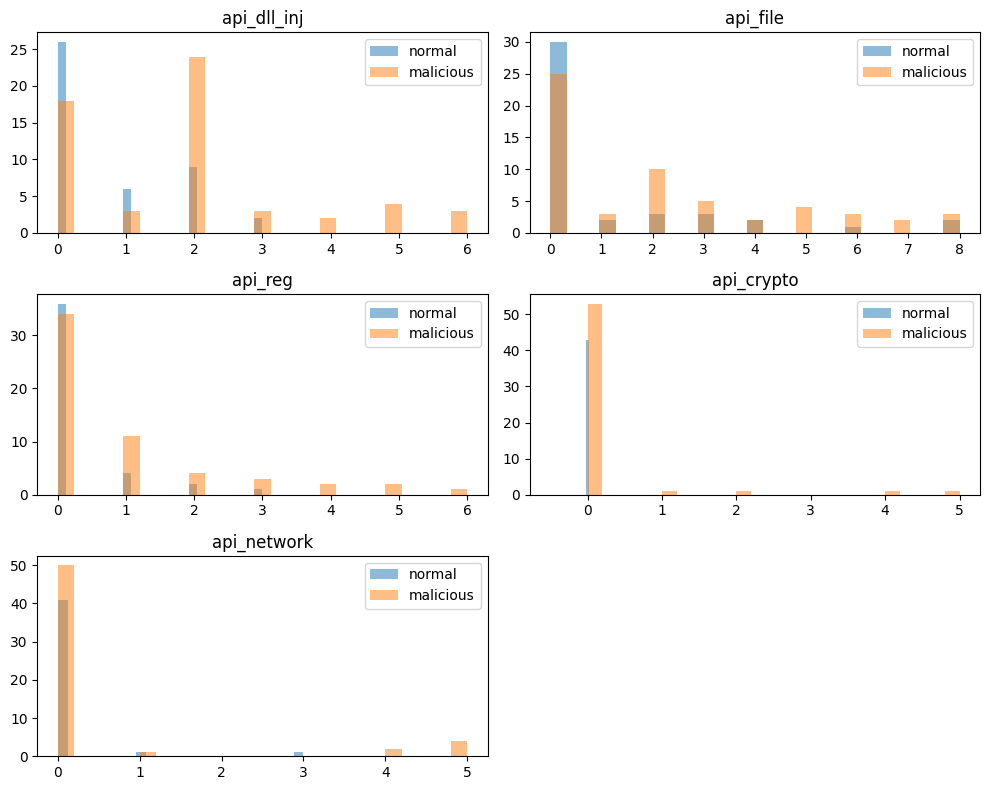

In [41]:
# prompt: 위의 5개 그래프를 모두 보여주는 코드 짜줘. 추가로 한눈에 들어올수있게 크기도 더 작게 조절해줘. 양식도 거의 비슷한데 for문으로해서 코드도 줄여줘

# 실행파일 악성여부로 구분하여 확인 - 다양한 API 카테고리
api_categories = ['api_dll_inj', 'api_file', 'api_reg', 'api_crypto', 'api_network']

plt.figure(figsize=(10, 8)) # 전체 Figure 사이즈 조정

for i, api_category in enumerate(api_categories):
    plt.subplot(3, 2, i + 1) # 서브플롯 위치 지정 (3행 2열)
    hist1 = df_temp[df_temp['target'] == 0][api_category]
    hist2 = df_temp[df_temp['target'] == 1][api_category]
    plt.hist(hist1, label='normal', alpha=0.5, bins=25)
    plt.hist(hist2, label='malicious', alpha=0.5, bins=25)
    plt.title(api_category) # 그래프 제목 추가
    plt.legend(loc=0)

plt.tight_layout() # 서브플롯 간 간격 자동 조정
plt.show()


### Yara Rule 매치 여부

In [43]:
df_temp = df_train_100.copy()

rule_file = colab_path + "yara_rules/malware_rules.yar"
yara_rule = open(rule_file, 'r').read()
rule = yara.compile(source=yara_rule)

df_temp['yara_malware'] = None
for idx, hash in enumerate(df_temp.index.values):
    filename = colab_path + 'data_train/' + hash
    f = open(filename, 'rb')
    data = f.read()
    matches = rule.match(data=data)
    if len(matches) != 0:
        df_temp.loc[hash, 'yara_malware'] = True
    else:
        df_temp.loc[hash, 'yara_malware'] = False


/tmp/ipython-input-43-4042744825.py:12: RuntimeWarning: too many matches for string $grammer_massacre in rule "PoetRat_Python"
  matches = rule.match(data=data)
/tmp/ipython-input-43-4042744825.py:12: RuntimeWarning: too many matches for string $grammer_massacre in rule "PoetRat_Python"
  matches = rule.match(data=data)
/tmp/ipython-input-43-4042744825.py:12: RuntimeWarning: too many matches for string $grammer_massacre in rule "PoetRat_Python"
  matches = rule.match(data=data)
/tmp/ipython-input-43-4042744825.py:12: RuntimeWarning: too many matches for string $grammer_massacre in rule "PoetRat_Python"
  matches = rule.match(data=data)
/tmp/ipython-input-43-4042744825.py:12: RuntimeWarning: too many matches for string $grammer_massacre in rule "PoetRat_Python"
  matches = rule.match(data=data)
/tmp/ipython-input-43-4042744825.py:12: RuntimeWarning: too many matches for string $grammer_massacre in rule "PoetRat_Python"
  matches = rule.match(data=data)
/tmp/ipython-input-43-4042744825.p

In [44]:
df_temp['yara_malware'].value_counts()

,count
yara_malware,
False,79
True,21


In [45]:
# 실행파일 악성여부로 피봇테이블 생성하여 확인
df_temp.groupby(['target', 'yara_malware']).count()

index_orig  is_PE  has_error  size  packer  ifc  \
target yara_malware                                                    
0      False                 40     40         40    40      40   40   
       True                   3      3          3     3       3    3   
1      False                 39     39         39    39      39   39   
       True                  18     18         18    18      18   18   

                     section_cnt  ts_entropy  rs_size  yara_https  \
target yara_malware                                                 
0      False                  40          40       40          40   
       True                    3           3        3           3   
1      False                  39          39       39          39   
       True                   18          18       18          18   

                     file_deleted_cnt_many  file_deleted_cnt_unknown  \
target yara_malware                                                    
0      False                            40                        40   
       True                              3                         3   
1      False                            39                        39   
       True                             18                        18   

                     file_deleted_cnt_zero  registry_runkey_modify_false  \
target yara_malware                                                        
0      False                            40                            40   
       True                              3                             3   
1      False                            39                            39   
       True                             18                            18   

                     registry_runkey_modify_true  \
target yara_malware                                
0      False                                  40   
       True                                    3   
1      False                                  39   
       True                                   18   

                     registry_runkey_modify_unknown  
target yara_malware                                  
0      False                                     40  
       True                                       3  
1      False                                     39  
       True                                      18

In [46]:
# prompt: target이 0인것중에 yara_malware가 true인것 표시

df_temp[(df_temp['target'] == 0) & (df_temp['yara_malware'] == True)]

,index_orig,target,is_PE,has_error,size,packer,ifc,section_cnt,ts_entropy,rs_size,yara_https,file_deleted_cnt_many,file_deleted_cnt_unknown,file_deleted_cnt_zero,registry_runkey_modify_false,registry_runkey_modify_true,registry_runkey_modify_unknown,yara_malware
hash,,,,,,,,,,,,,,,,,,
1581f524dec2cc3ba8bef37f3ab3d1fd.vir,872,0,True,False,-0.065766,MSLRH\nUPX\nUPX (Delphi) Stub\n,0x818f,-0.410197,1.376177,-0.053071,False,False,False,True,True,False,False,True
684d9ceda5e513ef9355df0eaa6e3271.vir,4064,0,True,False,-0.272386,Armadillo\nArmadillo\nMicrosoft Visual C++\nMi...,0x10f,-0.231911,0.088487,-0.063934,False,False,False,True,True,False,False,True
51ebb12e96ccb69d1f46ab0c9ccbdbfe.vir,3205,0,True,False,-0.216409,Visual C++ DLL\nMS Visual C++ DLL\nVisual C++ ...,0x2102,-0.053626,0.263029,-0.064170,False,False,True,False,False,False,True,True


## Feature 추가 추출 (종합)

In [ ]:
# 하나의 PE에 대해 인증서 정보 포함여부 확인
def has_cert(pe, filename):
    try:
        sig_offset = pe.OPTIONAL_HEADER.DATA_DIRECTORY[pefile.DIRECTORY_ENTRY["IMAGE_DIRECTORY_ENTRY_SECURITY"]].VirtualAddress
        sig_len = pe.OPTIONAL_HEADER.DATA_DIRECTORY[pefile.DIRECTORY_ENTRY["IMAGE_DIRECTORY_ENTRY_SECURITY"]].Size
        with open(filename, 'rb') as fh:
            fh.seek(sig_offset)
            sig = fh.read(sig_len)
        if len(sig) > 0:
            return True
        else:
            return False
    except Exception as e:
        pass

In [ ]:
# 하나의 PE에 대해 주요 DLL API 사용현황 추출
api_dict = {
    'api_dll_inj': ['OpenProcess','VirtualAllocEx','WriteProcessMemory','LoadLibraryA','GetProcAddress','CreateRemoteThread'],
    'api_file': ['WriteFile','lstrcmpiA','ReadFile','DeleteFileA','CreateFileA','CopyFileA','MoveFile','CreateProcessA','FindFirstFileA'],
    'api_reg': ['RegSetValueExA','RegEnumValueA','RegDeleteKeyA','RegCreateKeyExA','OpenProcessToken','RegOpenKeyExA'],
    'api_crypto': ['CryptEncrypt','CryptGenKey','CryptExportKey','CryptCreateHash','CryptHashData','CryptDeriveKey','CryptEncrypt','CryptGetHashParam','CryptAcquireContextA'],
    'api_network': ['WSAStartup','Gethostbyname','Gethostbyaddr','Socket','Send Recv']
}
def check_api(pe):
    result_dict = dict({'api_dll_inj':0, 'api_file':0,'api_reg':0,'api_crypto':0,'api_network':0,})
    try:
        pe.parse_data_directories()
        try:
            for entry in pe.DIRECTORY_ENTRY_IMPORT:
                for imp in entry.imports:
                    try:
                        api_name = imp.name.decode("utf8")
                        for (key, val) in api_dict.items():
                            if api_name in val:
                                result_dict[key] += 1
                    except:
                        pass
        except:
            pass
    except:
        pass

    return result_dict

In [ ]:
# 하나의 PE에 대해 yara rule 매치여부 확인
rule_file = colab_path + "yara_rules/malware_rules.yar"
yara_rule = open(rule_file, 'r').read()
rule = yara.compile(source=yara_rule)

def check_yara(filename):
    f = open(filename, 'rb')
    data = f.read()
    matches = rule.match(data=data)
    if len(matches) != 0:
        return True
    else:
        return False

In [ ]:
def feature_extract2(df, mode='train'):
    #Image file characteristics 개선
    df['is_RELOCS_STRIPPED'] = None
    df['is_DLL'] = None
    # cert정보 존재여부
    df['has_cert'] = False
    #import dll API 정보 반영
    df['api_dll_inj']=0
    df['api_file']=0
    df['api_reg']=0
    df['api_crypto']=0
    df['api_network']=0
    #yara rule 탐지 결과 반영
    df['yara_malware'] = None

    for idx, hash in enumerate(df.index.values):
        if idx % 50 == 0:
            print(idx)
        if mode == 'train':
            filename = colab_path + 'data_train/' + hash
        else:
            filename = colab_path + 'data_test/' + hash
        try:
            pe = pefile.PE(filename)
            # Image File Characteristics

            # cert정보 파싱

            # import dll & api

            # yara 룰 매치

        except Exception as e:
            df.loc[hash, 'has_error'] = False
    return df


In [ ]:
# 데이터 파일 로드
# 1차시도 전처리까지 마친 데이터에 추가적으로 Feature를 도출한다.
df_train = pd.read_csv(colab_path + "data_with_feature_csv/train_processed1.csv", index_col='hash')

In [ ]:
%%time
df_train = feature_extract2(df_train, 'train')

In [ ]:
df_train

In [ ]:
# 전처리/모델링에서 로드하여 사용
df_train.to_csv(colab_path + 'data_with_feature_csv/train_2nd.csv')

# 3-1. 분석용 데이터 준비: 전처리

In [ ]:
# 저장한 데이터 파일 로드
df_train = pd.read_csv(colab_path + "data_with_feature_csv/train_2nd.csv", index_col='hash')


### Feature 추출 중 오류가 난 data sample 제외

In [ ]:
# Feature 추출에 성공한 데이터만 학습에 사용
print(len(df_train))
df_train = df_train[df_train["has_error"]==False]
print(len(df_train))

In [ ]:
# 결측치 확인
df_train.isnull().sum()/len(df_train)*100

In [ ]:
# 데이터 정규화
# 데이터 정규화의 경우 sklean pipeline을 이용해 처리한다.

In [ ]:
# 추후 모델링을 위해 저장
df_train.to_csv(colab_path + 'data_with_feature_csv/train_processed2.csv')

# 3-4. 모델링 (sklearn pipeline 사용)

In [ ]:
# 전처리된 파일 로드
df_train = pd.read_csv(colab_path + "data_with_feature_csv/train_processed2.csv", index_col='hash')
df_train

In [ ]:
# 학습할 Feature 선택
target_col = 'target'
cols_to_exclude = ['index_orig', 'target', 'is_PE', 'has_error', 'packer', 'ifc', 'yara_https'] #ifc와 yara_https는 더 유의미한 Feature로 교체
train_y = df_train[target_col]
train_X = df_train.drop(columns = cols_to_exclude)
train_X

In [ ]:
# 훈련용/평가용 데이터 분할
# train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=42 )
# train_X

In [ ]:
# 파이프라인 구축
pipeline = Pipeline([
    ('scaler',preprocessing.StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
	])

# GridSearch 할 대상 하이퍼파라미터
params = {
    "clf__C": [1,5,10,20],  #모델인스턴스명__파라미터명
}
gs = GridSearchCV(pipeline, params)
gs.fit(train_X, train_y)
print("Best Score:" + str(gs.best_score_))
print("Best Parameter:" + str(gs.best_params_))

# best estimator를 pipeline에 반영
pipeline.set_params(**gs.best_params_)
pipeline.fit(train_X, train_y)

In [ ]:
# 모델 평가
scores = cross_val_score(pipeline, train_X, train_y)
scores.mean()

In [ ]:
# 베스트 모델 저장
save_dict ={
    "pipeline" : pipeline,
    "target_col": target_col,
    "cols_to_exclude" : cols_to_exclude
}
with open(colab_path + 'model/saved_model2.pickle','wb') as fw:
    pickle.dump(save_dict, fw)

# 3-6. 모델 적용 및 운영방안 수립

In [ ]:
# 저장된 모델 로드
with open(colab_path + 'model/saved_model2.pickle','rb') as f:
    saved_dict = pickle.load(f)
pipeline = saved_dict['pipeline']
target_col = saved_dict['target_col']
cols_to_exclude = saved_dict['cols_to_exclude']

In [ ]:
# 테스트용 데이터 로드
# 1차시도 전처리까지 마친 테스트 데이터에 추가적으로 Feature를 도출한다.
df_test = pd.read_csv(colab_path + "data_with_feature_csv/test_processed1.csv", index_col='hash')

In [ ]:
# feature 추출
df_test = feature_extract2(df_test, 'test')

In [ ]:
# 2차 전처리된 테스트용 데이터 저장
df_test.to_csv(colab_path + 'data_with_feature_csv/test_processed2.csv')

In [ ]:
# 2차 전처리된 테스트용 데이터 로드
df_test = pd.read_csv(colab_path + 'data_with_feature_csv/test_processed2.csv', index_col='hash')

In [ ]:
# 예측할 Feature 선택 및 X,y 분리
test_y = df_test[target_col]
test_X = df_test.drop(columns = cols_to_exclude)
test_X

In [ ]:
# 모델 성능 - accuracy
pipeline.score(test_X, test_y)

In [ ]:
# 테스트 데이터에 대한 예측 값 산출
pred_y = pipeline.predict(test_X)

# 모델 성능 - confusion matrix
conf_mat = confusion_matrix(y_true=test_y, y_pred=pred_y)
conf_mat

In [ ]:
# confusion matrix 시각화
plot_confusion_matrix(pipeline, test_X, test_y, normalize=None)